In [44]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, save_model

from sklearn.metrics import classification_report, confusion_matrix

%config InlineBackend.figure_format = 'svg'

In [45]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [46]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
tf.test.is_built_with_gpu_support()

True

In [48]:
data_dir = 'Weeds/updated_data/'

In [49]:
os.listdir(data_dir)

['test', 'train']

In [50]:
test_path = data_dir + 'test/'
train_path = data_dir + 'train/'

In [51]:
os.listdir(test_path)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'ShepherdΓÇÖs Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [52]:
os.listdir(train_path)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'ShepherdΓÇÖs Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [53]:
os.listdir(train_path + 'Black-grass')[0]

'103.png'

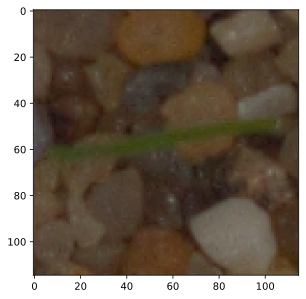

In [54]:
para_cell = (train_path + 'Black-grass\\' + '103.png')
plt.imshow(imread(para_cell))

In [55]:
os.listdir(train_path + 'Maize')[0]

'103.png'

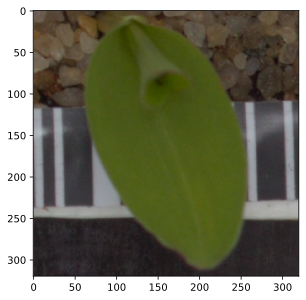

In [56]:
para_cell = (train_path + 'Maize\\' + '103.png')
plt.imshow(imread(para_cell))

In [57]:
for i in os.listdir(train_path):
    print(f'{i}: {len(os.listdir(train_path + i))}')

Black-grass: 612
Charlock: 612
Cleavers: 612
Common Chickweed: 612
Common wheat: 612
Fat Hen: 612
Loose Silky-bent: 612
Maize: 612
Scentless Mayweed: 612
ShepherdΓÇÖs Purse: 612
Small-flowered Cranesbill: 612
Sugar beet: 612


In [58]:
for i in os.listdir(test_path):
    print(f'{i}: {len(os.listdir(test_path + i))}')

Black-grass: 150
Charlock: 150
Cleavers: 150
Common Chickweed: 150
Common wheat: 150
Fat Hen: 150
Loose Silky-bent: 150
Maize: 150
Scentless Mayweed: 150
ShepherdΓÇÖs Purse: 150
Small-flowered Cranesbill: 150
Sugar beet: 150


In [59]:
# dim1 = []
# dim2 = []

# for i in os.listdir(test_path):
#     for image_filename in os.listdir(test_path + i):
#         img = imread(test_path + i + '\\' + image_filename)

#         d1, d2, colors = img.shape
#         dim1.append(d1)
#         dim2.append(d2)

In [60]:
# sns.jointplot(x = dim1, y = dim2)

In [61]:
# np.mean(dim1)

In [62]:
# np.mean(dim2)

In [63]:
IMG_SHAPE = (256, 256, 3)

In [64]:
380 * 380 * 3

433200

In [124]:
image_gen = ImageDataGenerator(
                                 rotation_range = 20, 
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               rescale = 1 / 255,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest'
                               )


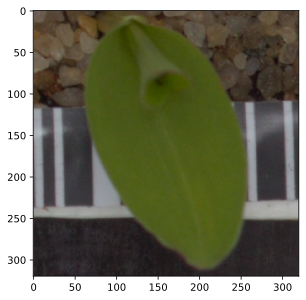

In [125]:
para_img = imread(para_cell)
plt.imshow(para_img)

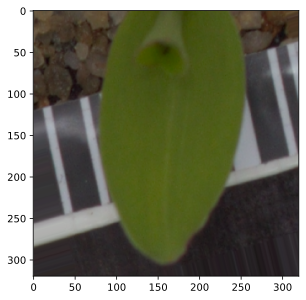

In [126]:
plt.imshow(image_gen.random_transform(para_img))

In [127]:
image_gen.flow_from_directory(train_path)

Found 7344 images belonging to 12 classes.


In [128]:
image_gen.flow_from_directory(test_path)

Found 1800 images belonging to 12 classes.


In [129]:
BATCH_SIZE = 8

In [130]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size = IMG_SHAPE[:2],
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'sparse',
                                                shuffle = True)

Found 7344 images belonging to 12 classes.


In [131]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size = IMG_SHAPE[:2],
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'sparse',
                                                shuffle = False)

Found 1800 images belonging to 12 classes.


In [132]:
train_image_gen.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'ShepherdΓÇÖs Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

## **`-3- Xception Model`**


In [133]:
XceptionModel = tf.keras.applications.xception.Xception(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
)

for layer in XceptionModel.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        XceptionModel,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(12, activation="softmax"),
    ]
)

model_ft.summary()

model_ft.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 12)                24588     
                                                                 
Total params: 20,886,068
Trainable params: 20,831,540
Non-trainable params: 54,528
_________________________________________________________________


In [134]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

In [139]:
saveCheckpointsPath = "XceptionWeed2/improved-{epoch:02d}-{val_accuracy:.2f}.hdf5"
Xceptioncheckpoint = ModelCheckpoint(saveCheckpointsPath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

In [140]:
logXception = CSVLogger("XceptionWeedLogs2.csv", separator = ',', append = False)

In [141]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is NOT available')

GPU is available


In [142]:
tf.debugging.set_log_device_placement(True)
with tf.device('/gpu:0'):
    history = model_ft.fit(
        train_image_gen,
        epochs=100,
        callbacks=[early_stop, Xceptioncheckpoint, logXception],
        validation_data=test_image_gen,
        verbose=1,
    )

Epoch 1/100
918/918 [==============================] - ETA: 0s - loss: 0.8836 - accuracy: 0.7151
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to XceptionWeed2\improved-01-0.57.hdf5
918/918 [==============================] - 220s 235ms/step - loss: 0.8836 - accuracy: 0.7151 - val_loss: 7.5499 - val_accuracy: 0.5750
Epoch 2/100
918/918 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.8679
Epoch 2: val_accuracy improved from 0.57500 to 0.74167, saving model to XceptionWeed2\improved-02-0.74.hdf5
918/918 [==============================] - 244s 265ms/step - loss: 0.3772 - accuracy: 0.8679 - val_loss: 0.8680 - val_accuracy: 0.7417
Epoch 3/100
918/918 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.9029
Epoch 3: val_accuracy improved from 0.74167 to 0.87389, saving model to XceptionWeed2\improved-03-0.87.hdf5
918/918 [==============================] - 254s 277ms/step - loss: 0.2820 - accuracy: 0.9029 - val_loss: 0.3563 - val_

In [143]:
model_ft.save('XceptionWeedModel.hdf5')

In [144]:
model_ft.metrics_names

['loss', 'accuracy']

In [145]:
model_ft.evaluate(test_image_gen)

225/225 [==============================] - 34s 151ms/step - loss: 1.5333 - accuracy: 0.9106


[1.5333139896392822, 0.9105555415153503]

In [146]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

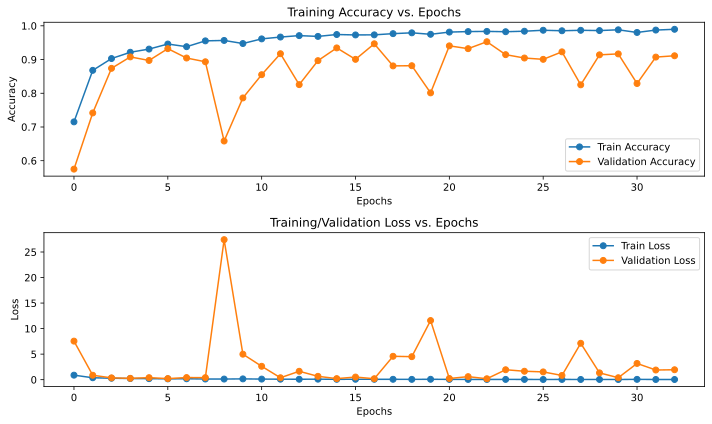

In [147]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [150]:
df = pd.read_csv('XceptionPestlogs.csv')

In [151]:
train_accuracy = df['accuracy']
val_accuracy = df['val_accuracy']

train_loss = df['loss']
val_loss = df['val_loss']

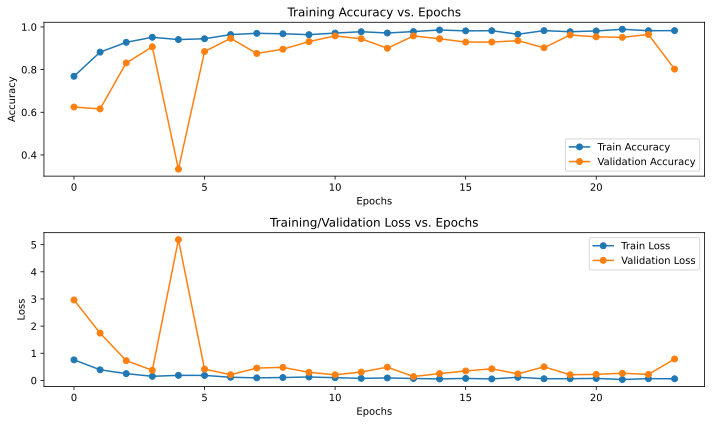

In [152]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('XceptionPlot.png')
plt.show()

In [170]:
model = load_model('XceptionWeedModel.hdf5')

In [171]:
from sklearn.metrics import classification_report, confusion_matrix

In [172]:
pred = model.predict(test_image_gen)

225/225 [==============================] - 36s 155ms/step


In [177]:
labels = {value: key for key, value in train_image_gen.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Black-grass
1 : Charlock
2 : Cleavers
3 : Common Chickweed
4 : Common wheat
5 : Fat Hen
6 : Loose Silky-bent
7 : Maize
8 : Scentless Mayweed
9 : ShepherdΓÇÖs Purse
10 : Small-flowered Cranesbill
11 : Sugar beet


In [178]:
y_pred = np.argmax(pred, axis = 1)
y_test = test_image_gen.classes

In [179]:
print(classification_report(y_test, y_pred, target_names=labels.values()))

                           precision    recall  f1-score   support

              Black-grass       0.91      0.69      0.78       150
                 Charlock       0.81      0.99      0.89       150
                 Cleavers       0.98      0.99      0.98       150
         Common Chickweed       0.90      0.99      0.94       150
             Common wheat       0.97      0.93      0.95       150
                  Fat Hen       0.97      0.99      0.98       150
         Loose Silky-bent       0.74      0.95      0.84       150
                    Maize       1.00      0.65      0.79       150
        Scentless Mayweed       0.97      0.97      0.97       150
       ShepherdΓÇÖs Purse       0.93      0.95      0.94       150
Small-flowered Cranesbill       1.00      0.83      0.91       150
               Sugar beet       0.86      0.99      0.92       150

                 accuracy                           0.91      1800
                macro avg       0.92      0.91      0.91    

<Axes: >

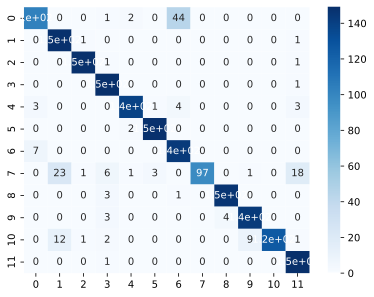

In [180]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linecolor = 'white', cmap = 'Blues')